In [1]:
for i in range(0, 52, 1):
    filename = (str(i) + ".inp")
    target = open(filename, 'w+')
    pos = 0.5 * i * (1 / 50)
    target.write("""include /home/ben/Documents/gulp/data_files/na3ocl_structure.inp
""")
    target.write(f"centre 0.5 {pos:.16f} {0.5 - pos:.16f}")
    target.write("""
size 12 16
vacancy 0.5 0.5 0.0
vacancy 0.5 0.0 0.5
""")
    target.write(f"intersitial Na 0.5 {pos:.16f} {0.5 - pos:.16f} fix")
    target.write("""
include /home/ben/Documents/gulp/data_files/na3ocl_potentials.inp    
""")

In [2]:
import subprocess
from time import sleep
import random

def gulp(input_path):
    sleep(random.random())
    run = True
    output_path = input_path[:-3] + 'out'
    try:
        with open(output_path) as f:
            file = f.read()
        if 'Job Finished at' in file:
            run = False
    except:
        pass
    if run:
        with open(input_path) as f:
            output_path = input_path[:-3] + 'out'
            with open(output_path, 'w') as o:
                try:
                    a = subprocess.run(['gulp'], stdin = f, stdout = o, timeout = 900)
                except:
                    pass

In [3]:
import glob
import subprocess
from tqdm import tqdm
import multiprocessing

# n = 5
# species = 'Sr'

all_cases = sorted(glob.glob('*.inp'), key = lambda x: x.split('/')[-1].split('.')[0])

complete = []

for case in all_cases:
    try:
        with open(case[:-3] + 'out', 'r') as f:
            g = f.read()
        if 'Final energy' in g:
            complete.append(case)
    except:
        pass

cases = [case for case in all_cases if case not in complete]

N = len(cases)

def update():
    pbar.update(1)

if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        for result in tqdm(pool.imap_unordered(gulp, cases), total=len(cases)):
            pass
    pool.close()
    pool.join()

100%|██████████| 52/52 [14:20<00:00, 16.56s/it]


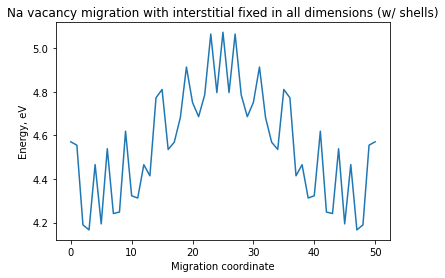

In [5]:
from matplotlib import pyplot as plt
import re
import glob
import numpy as np

position, energy = [], []

data = glob.glob('*.out')

def getEnergy(path):
    with open(path) as file:
        content = file.readlines()
    for line in content:
        if "Final defect energy" in line:
            return float(re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", line)[0])

for f in data:
    position.append(float(f.strip('.out')))
    energy.append(getEnergy(f))

energies = np.array(energy)
positions = np.array(position)
idx   = np.argsort(positions)

energies = np.array(energies)[idx]
positions = np.array(positions)[idx]

plt.plot(positions, energies)
plt.ylim()
plt.xlabel('Migration coordinate')
plt.ylabel('Energy, eV')
plt.title('Na vacancy migration with interstitial fixed in all dimensions (w/ shells)')
plt.savefig('/home/ben/Documents/gulp_calcs/0_summary/plot_na3ocl_fix_shel.jpg', bbox_inches='tight', dpi=500)